# Proyecto 04 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

En este notebook partimos de los resultados obtenidos en el proyecto 3 y utilizando prophet vemos si podemos mejorar el modelo y reducir el error utilizando igual que en el proyecto anterior el RMSE como parámetro de medición del error.

Tomamos como punto de partida benchmark del proyecto 3 donde el rmse es:6949 autos por día

Luego utilizando xgboot y haciendo ingeniería de variables y optimizando hiper parámetros se logra bajar el rmse a:5077 autos por día

Ahora Utilizando Prophet veremos si podemos mejorar esas predicciones siempre trabajando sobre último trimestre del año 2019 con autopista Illia y forma de pago efectivo.


### 1. Preparación del Dataset


In [2]:
#data[data.date_check != datetime.timedelta(1)] funciona revisar para obtener fechas faltantes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import sqlite3
import os
import datetime
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp
from matplotlib.dates import MonthLocator, num2date
from matplotlib.ticker import FuncFormatter
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import itertools
from fbprophet.diagnostics import performance_metrics

Importing plotly failed. Interactive plots will not work.


In [3]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
#data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')


In [4]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [5]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [6]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [8]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())


['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [9]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())
#print(data_2016['sentido'].unique())


['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [10]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())


['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [11]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())


['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [12]:
print("Tamaño del dataset 2017: ", data_2017.shape)
print("Tamaño del dataset 2018: ", data_2018.shape)
print("Tamaño del dataset 2019: ", data_2019.shape)
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])
print(dataset.head)
dataset.head()

datasetoriginal=dataset #guardamos una copia original del dataset

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

Tamaño del dataset 2017:  (1372645, 10)
Tamaño del dataset 2018:  (1375908, 10)
Tamaño del dataset 2019:  (812153, 10)
<bound method NDFrame.head of          periodo       fecha  hora_inicio  hora_fin      dia    estacion  \
0           2019  2019-01-01            0         1   Martes     Alberti   
1           2019  2019-01-01            0         1   Martes     Alberti   
2           2019  2019-01-01            0         1   Martes     Alberti   
3           2019  2019-01-01            0         1   Martes     Alberti   
4           2019  2019-01-01            0         1   Martes  Avellaneda   
...          ...         ...          ...       ...      ...         ...   
1372640     2017  2017-12-31           22        23  Domingo   Sarmiento   
1372641     2017  2017-12-31           22        23  Domingo   Sarmiento   
1372642     2017  2017-12-31           22        23  Domingo   Sarmiento   
1372643     2017  2017-12-31           23         0  Domingo   Sarmiento   
1372644     201

In [13]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [14]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [15]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


In [16]:
#Resampleamos nuestros datos para agrupar por dia, e ir armando la estructura de datos para prophet
diario = dataset[['cantidad_pasos','dia','fecha']].resample('D', on = 'fecha').sum()
ds=diario
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


In [17]:

ds['fecha']=pd.to_datetime(diario.index)#armamos dataset para prophet ya dejando filtrada la el rango de fechas a utilizar para predecir
ds=ds.set_index('fecha')
ds=ds.loc['2017-01-01':'2019-09-30']
ds


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486
...,...
2019-09-26,43110
2019-09-27,44985
2019-09-28,41925


Empezamos a procesar el dataset, para armar un modelo para predecir la cantidad de pasadas para el último trimestre del año 2019. Vamos a armar un modelo de prophet incluyendo los feriados y eventos específicos, como los detectados originalmente en la serie que son días que no tienen registros de pasos de autos por ser paros nacionales o G20

In [51]:
# Armamos el dataset como lo utiliza prophet
def modelar(periodo,feriados,imprevistos):#función para ensabmlar el dataset
        dfprphet =pd.DataFrame(columns=['ds', 'y'])
        dfprphet['ds']=periodo.index # asignamos las variables predictora al dataset para prophet
        dfprphet['y']=periodo.cantidad_pasos.values # asígnanos la variables a predecir al dataset de propet
        
        diasesp=pd.concat((feriados,imprevistos)) # unificamos los dataset para armar el modelo de propehet con dias feriados
        modelarprop=Prophet(holidays=diasesp) # armamos el modelo con los feriados
        return modelarprop, dfprphet

import holidays # incorporamos los feriados para los años 2017 al 2019
feriados=[]
for date, name in sorted(holidays.AR(years=[2017,2018,2019]).items()):
        feriados.append(date)

feriprophet=pd.DataFrame({'holiday':'Feriados','ds':feriados}) # creamos el dataset de feriados
fechas=['2017-04-06','2018-06-25','2018-09-25','2018-11-30','2019-05-29'] # generamos una lista con las fechas detectadas que son días donde no hubo registros de pasos de vehiculos

fechasimp=pd.DataFrame({'holiday':'Imprevistos','ds':fechas})# creamos el dataset de eventos imprevistos


modprophet, dfprphet=modelar(ds,feriprophet,fechasimp)
modprophet.fit(dfprphet) # entrenamos el modelo con el dataset



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [52]:
fintrim2019=modprophet.make_future_dataframe(periods=92) # Definimos la cantidad de días a futuro que queremos predecir
forecast=modprophet.predict(fintrim2019) # Realzamos la predicción
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
print('error en el modelo base:', int(np.sqrt(mean_squared_error(diario.cantidad_pasos, forecast.yhat))))



ValueError: Found input variables with inconsistent numbers of samples: [1095, 1187]

Vemos que entrenando el modelo con hiper parámetros por defecto ya es relativamente mejor que el benchmark y el modelo optimizado de xgboot

Graficamos los resultados obtenido de la predicción


In [49]:
#graficamos la serie y la predicción realizada con prophet y la comparamos contra el gráfico de los datos reales
fig1=modprophet.plot(forecast,figsize=(20,5))
sns.lineplot(x=diario.index,y=diario.cantidad_pasos.values,label='Pasos Realies',color='y')
plt.title("Cantidad de pasos Reales Vs pasos predichos periodo 2017 al 2019")
plt.show()

TypeError: 'NoneType' object is not subscriptable

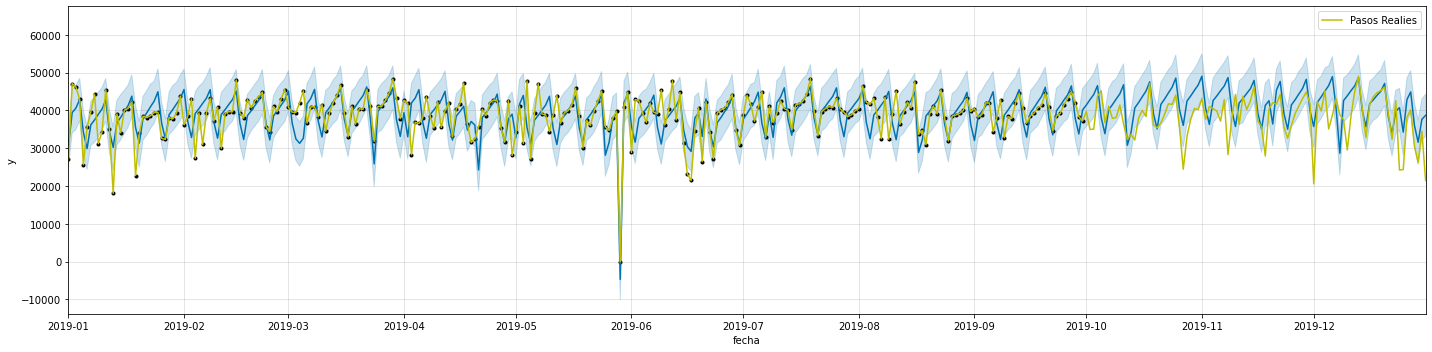

In [21]:
#hacemos un zoom al gráfico para poder visualizar mejor las series
fig1=modprophet.plot(forecast,figsize=(20,5))
sns.lineplot(x=diario.index,y=diario.cantidad_pasos.values,label='Pasos Realies',color='y')
plt.xlim(datetime(2019,1,1), datetime(2019,12,31))
plt.show()

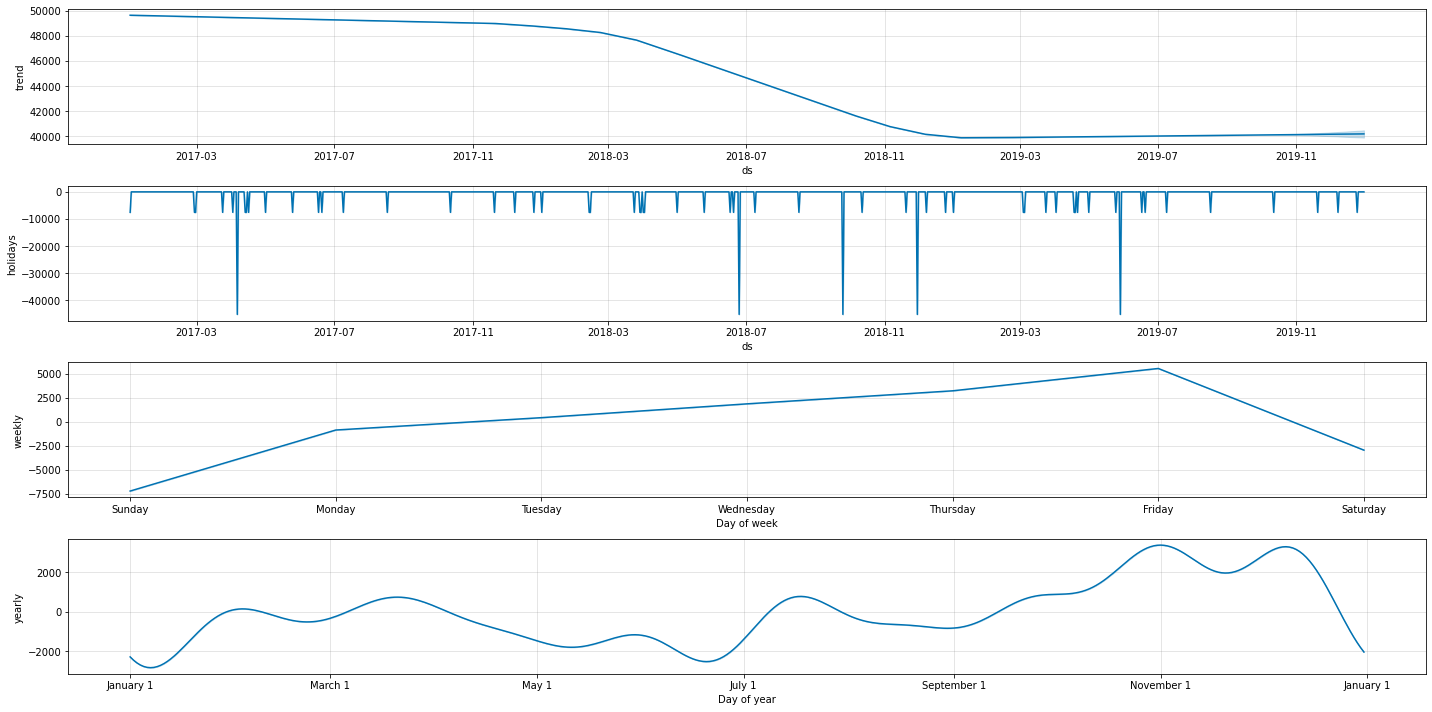

In [22]:
fig2 = modprophet.plot_components(forecast,figsize=(20,10))#Obtenemos la graficas de los componentes, Tendencia, feriados, estacionalidad semanal y anual

In [23]:
#incorporamos los feriados según calendario de ministerio del interior, para ver si mejoran los resultados, ya que la funcion holiday son fechas estáticas y en Argentian hay feriados cuyas fechas se corren vemos si mejora la predicción.

feriados=['2017-01-01','2017-02-27','2017-02-28','2017-03-24','2017-04-02','2017-04-14','2017-05-01','2017-05-25','2017-06-20','2017-07-09','2017-08-21','2017-10-16','2017-11-20','2017-12-08','2017-12-09','2017-12-25','2018-01-01','2018-02-13','2018-02-14','2018-03-24','2018-03-30','2018-04-02','2018-04-30','2018-05-01','2018-05-25','2018-06-17','2018-06-20','2018-07-09','2018-08-20','2018-10-16','2018-11-20','2018-12-08','2018-12-24','2018-12-25','2019-01-01','2019-02-04','2019-02-05','2019-03-24','2019-04-02','2019-04-19','2019-05-01','2019-05-25','2019-06-17','2019-06-20','2019-07-08','2019-07-09','2019-08-17','2019-08-19','2019-10-12','2019-10-14','2019-11-18','2019-12-08','2019-12-25']
feriprophet=pd.DataFrame({'holiday':'Feriados','ds':feriados})

In [24]:
# Entrenamos de nuevo el modelo con los nuevos feriados

diasesp=pd.concat((feriprophet,fechasimp))
modprophetm2=Prophet(holidays=diasesp)
modprophetm2.fit(dfprphet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
fintrim2019=modprophet.make_future_dataframe(periods=92)
forecast=modprophetm2.predict(fintrim2019)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
print('error en el modelo Feriados Ministerios del interior:', int(np.sqrt(mean_squared_error(diario.cantidad_pasos, forecast.yhat))))

error en el modelo Feriados Ministerios del interior: 4579



Vemos que el modelo mejora levemente al utilizar los feriados ajustados por el ministerio del interior en vez de utilizar la funciona holidays


In [26]:
# Realizamos optimización de hiperparámetros y validación cruzada y ver si podemos reducir el error.

#import numpy as np
#import pandas as pd
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 0.5, 1.0, 5, 10.0],
    'holidays_prior_scale':[0.01, 0.1, 0.5, 1.0, 5, 10.0],
}
# Generamos las combinaciones de los hiper parámetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Variable para almacenar el corte

# Realizamos la validación cruzada
for params in all_params:
    m = Prophet(**params).fit(dfprphet)  # entrenamos el modelo con los parámetros de la lista
    df_cv = cross_validation(m,  initial='637 days', period='365.25 days', horizon = '92 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# obtenemos el mejor parámetro
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-06-30 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001B4916CC970>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-06-30 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001B492D85520>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-06-30 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001B4916DDC70>
INFO:fbprophet:Disabling daily seasonali

In [53]:
best_params = all_params[np.argmin(rmses)] #Obtenemos los mejores hiper parámetros
print("Los mejores Hiper parámetros:",all_params[np.argmin(rmses)])
#Armamos un dataset con la combinación de hiperparametros y los RMSE resultantes por cada modelo entrenado
bp=pd.DataFrame(all_params)
bp['rmse']=pd.DataFrame({'rmse':rmses})
bp

Los mejores Hiper parámetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01}


,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,rmse
0,0.001,0.01,0.01,3661.875647
1,0.001,0.01,0.10,3661.875647
2,0.001,0.01,0.50,3661.875647
3,0.001,0.01,1.00,3661.875647
4,0.001,0.01,5.00,3661.875647
...,...,...,...,...
139,0.500,10.00,0.10,4055.918335
140,0.500,10.00,0.50,4055.918335
141,0.500,10.00,1.00,4055.918335
142,0.500,10.00,5.00,4055.918335


De la validación cruzada y optimización de hiper parámetros, vemos que logramos reducir más el error llegando a un valor de rmse 3661.
Vemos que con prophet logramos reducir el error y por lo cual obtenemos una mejor predicción que con el modelo armado para xgboot en el proyecto3




In [28]:
#Ahora con la el modelo optimizado, vamos a precedir los primeros 60 días del año 2020. No se predice mas de ese tiempo por efecto de covid los valores a partir del 29 de febrero no van ha ser predichos correctamente tal como lo visto en el proyecto 3
#vamos a utlizar los años 2017,2018 y 2019 completos para preder el primer bimestre.
ds=diario
ds['fecha']=pd.to_datetime(diario.index)#armamos dataset para prophet ya dejando filtrada la el rango de fechas a utilizar para predecir
ds=ds.set_index('fecha')
modprophet, dfprphet=modelar(ds,feriprophet,fechasimp)
hparam=[{'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'holidays_prior_scale': 0.01}]

m = Prophet(**params).fit(dfprphet)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<function matplotlib.pyplot.show(*args, **kw)>

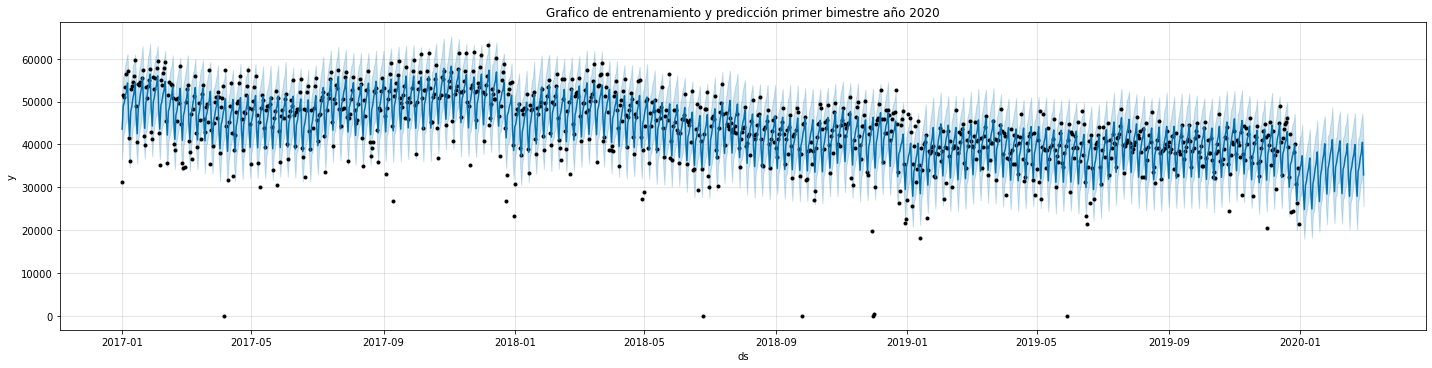

In [54]:
fptrim2020=m.make_future_dataframe(periods=60)
ptrim2020=m.predict(fptrim2020)# predecimos y graficamos la predicción
fig1=m.plot(ptrim2020,figsize=(20,5))
plt.title("Gráfico de entrenamiento y predicción primer bimestre año 2020")
plt.show


In [47]:
#Ahora calculamso el RMSE y comparamos la grafica real contra la predicha para ver como ajusta gráficamente la predicción
dataset2020=pd.read_csv('flujo-vehicular-2020.csv', sep =',')

mask = np.logical_and(dataset2020.estacion=='ILLIA', dataset2020.forma_pago == 'Efectivo')
dataset2020 = dataset2020[mask]

#Quitamos las columnas que no vamos a utilizar
dataset2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)
dataset2020['fecha2'] = pd.to_datetime(dataset2020.fecha) + pd.to_timedelta(dataset2020.hora_fin, unit = 'h')
#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset2020.drop(columns=['fecha','hora_fin'], inplace = True)

dataset2020.rename(columns = {'fecha2':'fecha'}, inplace = True)
dataset2020.sort_values('fecha', inplace = True)
dataset2020.reset_index(drop=True, inplace = True)
diario2020 = dataset2020[['cantidad_pasos','dia','fecha']].resample('D', on = 'fecha').sum()
dataset2020m2=diario2020.loc['2020-01-01':'2020-02-29'] #Filtramos por el periodo que predecimos 


error predicción enero-febrero 2020: 3115


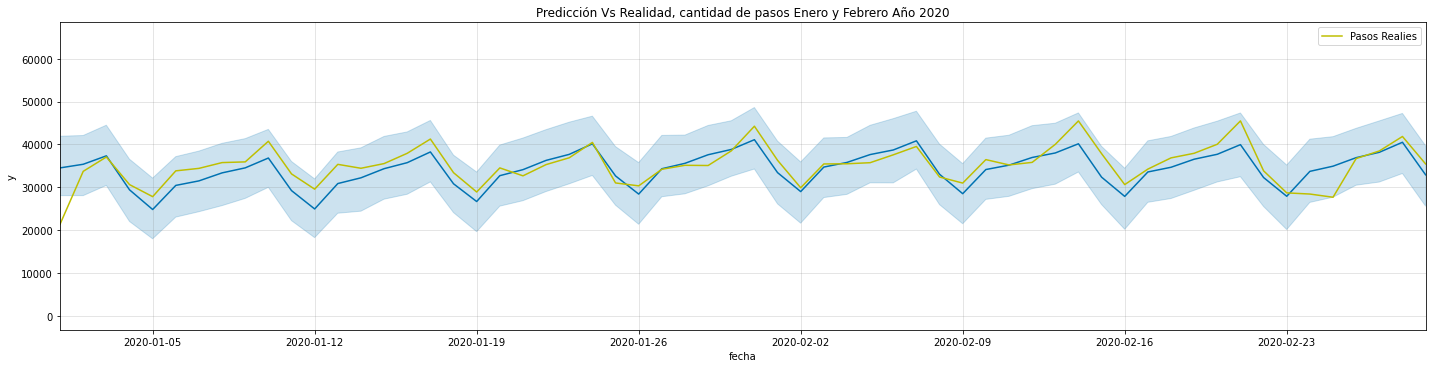

In [55]:
ptrim2020[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
mask=np.logical_and(ptrim2020.ds>='2020-01-1',ptrim2020.ds<='2020-02-29')
error=ptrim2020[mask]
print('error predicción enero-febrero 2020:', int(np.sqrt(mean_squared_error(dataset2020m2.cantidad_pasos, error.yhat))))
fig1=m.plot(ptrim2020,figsize=(20,5))
sns.lineplot(x=dataset2020m2.index,y=dataset2020m2.cantidad_pasos.values,label='Pasos Realies',color='y')
plt.xlim(datetime(2020,1,1), datetime(2020,2,29))
plt.title("Predicción Vs Realidad, cantidad de pasos Enero y Febrero Año 2020")
plt.show()


Vemos que utilizando prophet mejoramos significativamente la predicción que al utilizar xgboot, también para el tipo de problema presentado con prophet el esfuerzo para mejor el modelo no requiere tanto labor como al utilizar xgboot en el cual se requiere hacer ingeniería de variables para ir mejorando el modelo y aún así no se logra alcanzar los resultados obtenidos con prophet.